# 1 Install StellarGraph

In [1]:
!pip install stellargraph

     |████████████████████████████████| 127 kB 1.0 MB/s eta 0:00:01
ERROR: influxdb-client 1.36.1 has requirement urllib3>=1.26.0, but you'll have urllib3 1.25.11 which is incompatible.
ERROR: aiobotocore 2.5.0 has requirement botocore<1.29.77,>=1.29.76, but you'll have botocore 1.29.142 which is incompatible.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.2
    Uninstalling urllib3-2.0.2:
      Successfully uninstalled urllib3-2.0.2


# 2 Load dataset and data preprocessing

## 2.1 Load edge list

In [2]:
import pandas as pd
patient_graph = pd.read_csv(
   "./personalgraph.csv",
)
patient_graph.head()
## e.g. source 0 and target 193 means patient 0 is linked to patient 193 (they have common diseases)

,source,target
0,0,193
1,0,37
2,0,40
3,0,1838
4,0,1200


In [3]:
patient_content = pd.read_csv("patient.csv")
patient_raw_content = patient_content.drop(columns=['person_id'])
patient_raw_content.head()
# gender: 0 is male and 1 is female, age is normalised, smoker: 0 is non smoker and 1 is smoker.

,patient_id,gender,age,smoker,label
0,0,0,0.842105,0,0
1,1,1,0.938596,0,0
2,2,1,0.938596,0,0
3,3,0,0.780702,0,0
4,4,1,0.903509,0,1


In [4]:
patient_content_str_subject = patient_raw_content.set_index("patient_id")
patient_content_no_label = patient_content_str_subject.drop(columns="label")
patient_label = patient_content_str_subject["label"]
patient_content_one_hot_subject = pd.get_dummies(
    patient_content_str_subject, columns=["label"]
)

In [5]:
from stellargraph import StellarGraph
patient_one_hot_subject = StellarGraph(
    {"patient": patient_content_one_hot_subject}, {"graph": patient_graph}
)
print(patient_one_hot_subject.info())

StellarGraph: Undirected multigraph
 Nodes: 2814, Edges: 208910

 Node types:
  patient: [2814]
    Features: float32 vector, length 5
    Edge types: patient-graph->patient

 Edge types:
    patient-graph->patient: [208910]
        Weights: all 1 (default)
        Features: none


# 3. GNN models

In [6]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
train_label, test_label = model_selection.train_test_split(
    patient_label, train_size=0.6, test_size=None, random_state = 2)

val_label, test_label = model_selection.train_test_split(
    test_label, train_size=0.5, test_size=None,random_state = 2)

In [8]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_label)
val_targets = target_encoding.transform(val_label)
test_targets = target_encoding.transform(test_label)

all_targets = target_encoding.transform(patient_label)

In [9]:
## training
sg.random.set_seed(42)
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

generator = FullBatchNodeGenerator(patient_one_hot_subject, method="gcn", weighted = True)
train_gen = generator.flow(train_label.index, train_targets)
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.3
)
x_inp_gcn, x_out_gcn = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out_gcn)
modelGCN = Model(inputs=x_inp_gcn, outputs=predictions)
modelGCN.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=["acc"],
)
val_gen = generator.flow(val_label.index, val_targets)

from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=30, restore_best_weights=True)


history = modelGCN.fit(
    train_gen,
    epochs=1000,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Using GCN (local pooling) filters...
Epoch 1/1000


/Users/ben/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/ben/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 - 1s - loss: 0.7077 - acc: 0.3910 - val_loss: 0.6957 - val_acc: 0.3979 - 847ms/epoch - 847ms/step
Epoch 2/1000
1/1 - 0s - loss: 0.6949 - acc: 0.3981 - val_loss: 0.6821 - val_acc: 0.6163 - 74ms/epoch - 74ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.6790 - acc: 0.6291 - val_loss: 0.6673 - val_acc: 0.7460 - 76ms/epoch - 76ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.6683 - acc: 0.6410 - val_loss: 0.6484 - val_acc: 0.8171 - 75ms/epoch - 75ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.6462 - acc: 0.7927 - val_loss: 0.6280 - val_acc: 0.8668 - 73ms/epoch - 73ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.6309 - acc: 0.8377 - val_loss: 0.6090 - val_acc: 0.8828 - 74ms/epoch - 74ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.6097 - acc: 0.8590 - val_loss: 0.5914 - val_acc: 0.8579 - 72ms/epoch - 72ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.5939 - acc: 0.8217 - val_loss: 0.5739 - val_acc: 0.8579 - 72ms/epoch - 72ms/step
Epoch 9/1000
1/1 - 0s - loss: 0.5822 - acc: 0.8353 - val_loss: 0.5560 - val_acc: 0.8579 - 71ms/epoch - 71ms

1/1 - 0s - loss: 0.2999 - acc: 0.8596 - val_loss: 0.2388 - val_acc: 0.9023 - 68ms/epoch - 68ms/step
Epoch 74/1000
1/1 - 0s - loss: 0.2832 - acc: 0.8667 - val_loss: 0.2301 - val_acc: 0.9023 - 68ms/epoch - 68ms/step
Epoch 75/1000
1/1 - 0s - loss: 0.2786 - acc: 0.8697 - val_loss: 0.2297 - val_acc: 0.9005 - 69ms/epoch - 69ms/step
Epoch 76/1000
1/1 - 0s - loss: 0.2780 - acc: 0.8744 - val_loss: 0.2409 - val_acc: 0.8970 - 70ms/epoch - 70ms/step
Epoch 77/1000
1/1 - 0s - loss: 0.2729 - acc: 0.8786 - val_loss: 0.2550 - val_acc: 0.8845 - 68ms/epoch - 68ms/step
Epoch 78/1000
1/1 - 0s - loss: 0.2886 - acc: 0.8732 - val_loss: 0.2456 - val_acc: 0.8970 - 76ms/epoch - 76ms/step
Epoch 79/1000
1/1 - 0s - loss: 0.2802 - acc: 0.8632 - val_loss: 0.2311 - val_acc: 0.8988 - 77ms/epoch - 77ms/step
Epoch 80/1000
1/1 - 0s - loss: 0.2716 - acc: 0.8750 - val_loss: 0.2296 - val_acc: 0.8988 - 79ms/epoch - 79ms/step
Epoch 81/1000
1/1 - 0s - loss: 0.2740 - acc: 0.8667 - val_loss: 0.2381 - val_acc: 0.9023 - 79ms/epoch 

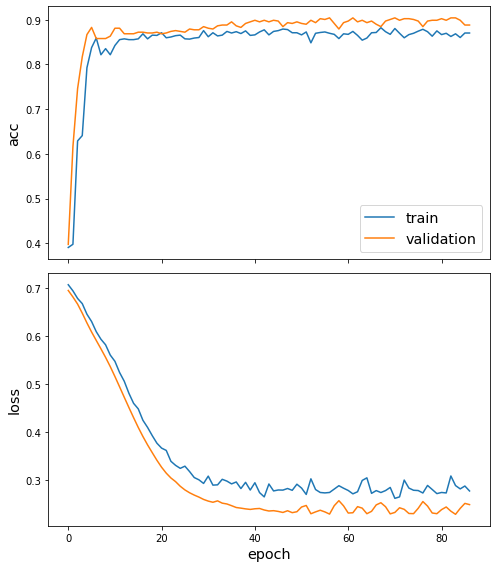

In [10]:
sg.utils.plot_history(history)

In [11]:
test_gen = generator.flow(test_label.index, test_targets)

In [12]:
# test accuracy
test_metrics = modelGCN.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(modelGCN.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 48ms/step - loss: 0.2823 - acc: 0.8668

Test Set Metrics:
	loss: 0.2823
	acc: 0.8668


In [13]:
all_nodes = patient_label.index
all_gen = generator.flow(all_nodes)
all_predictions = modelGCN.predict(all_gen)

In [14]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [16]:
# prediciton for training set
df = pd.DataFrame({"Predicted": node_predictions, "True": patient_label})
df.head()

,Predicted,True
patient_id,,
0,0,0
1,1,0
2,0,0
3,0,0
4,1,1


In [17]:
# Confusion matrix for training set
pd.crosstab(patient_label, node_predictions, rownames=["true"], colnames=["predicted"])

predicted,0,1
true,,
0,1171,236
1,95,1312


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [19]:
test_nodes = test_label.index
test_gen = generator.flow(test_nodes)
test_predictions = modelGCN.predict(test_gen)

In [20]:
test_node_predictions = target_encoding.inverse_transform(test_predictions.squeeze())

In [22]:
# prediction for testing set
df = pd.DataFrame({"Predicted": test_node_predictions, "True": test_label})
df.head()

,Predicted,True
patient_id,,
1827,1,0
1895,1,0
355,0,0
1572,0,0
1852,0,0


In [23]:
# confusion matrix for testing set
pd.crosstab(test_label, test_node_predictions, rownames=["true"], colnames=["predicted"])

predicted,0,1
true,,
0,225,52
1,23,263


In [24]:
print(confusion_matrix(test_label, test_node_predictions))
print(classification_report(test_label, test_node_predictions, digits=4))

[[225  52]
 [ 23 263]]
              precision    recall  f1-score   support

           0     0.9073    0.8123    0.8571       277
           1     0.8349    0.9196    0.8752       286

    accuracy                         0.8668       563
   macro avg     0.8711    0.8659    0.8662       563
weighted avg     0.8705    0.8668    0.8663       563



In [25]:
# AUC
from sklearn import metrics
roc_auc = metrics.roc_auc_score(test_label, test_node_predictions)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.8659273939057333


In [26]:
# Visualisation
embedding_model = Model(inputs=x_inp_gcn, outputs=x_out_gcn)
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2814, 16)

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = PCA  # or PCA

In [28]:
X = emb.squeeze(0)
X.shape

(2814, 16)

In [29]:
# 2d
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2814, 2)

In [30]:
# 3D
trans = transform(n_components=3)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2814, 3)

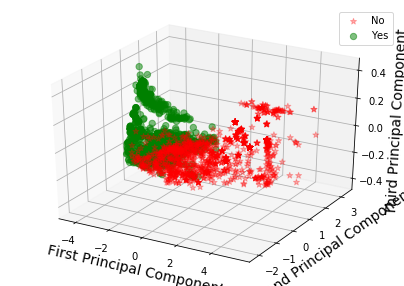

In [32]:
from mpl_toolkits.mplot3d import Axes3D 
ex_variance=np.var(X_reduced,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio


Xax = X_reduced[:,0]
Yax = X_reduced[:,1]
Zax = X_reduced[:,2]

cdict = {0:'red',1:'green'}
labl = {0:'No',1:'Yes'}
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

y = patient_label
fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend()
plt.show()

# GAT

In [33]:
from stellargraph.layer import GAT

In [34]:

sg.random.set_seed(42)
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

generator = FullBatchNodeGenerator(patient_one_hot_subject, method="gat", weighted = True)
train_gen = generator.flow(train_label.index, train_targets)
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "sigmoid"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.3,
    attn_dropout=0.0,
    normalize=None,
)

x_inp_gat, x_out_gat = gat.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out_gat)


modelGAT = Model(inputs=x_inp_gat, outputs=predictions)
modelGAT.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=["acc"],
)

val_gen = generator.flow(val_label.index, val_targets)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=30
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

history = modelGAT.fit(
    train_gen,
    epochs=1000,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/1000


/Users/ben/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/ben/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 - 3s - loss: 0.7297 - acc: 0.5006 - val_loss: 0.6974 - val_acc: 0.5062 - 3s/epoch - 3s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6934 - acc: 0.5006 - val_loss: 0.6788 - val_acc: 0.5062 - 365ms/epoch - 365ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.6751 - acc: 0.5006 - val_loss: 0.6657 - val_acc: 0.5062 - 395ms/epoch - 395ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.6623 - acc: 0.5012 - val_loss: 0.6559 - val_acc: 0.5062 - 353ms/epoch - 353ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.6508 - acc: 0.5030 - val_loss: 0.6473 - val_acc: 0.5062 - 358ms/epoch - 358ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.6458 - acc: 0.5000 - val_loss: 0.6382 - val_acc: 0.5062 - 342ms/epoch - 342ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.6360 - acc: 0.5047 - val_loss: 0.6271 - val_acc: 0.5098 - 399ms/epoch - 399ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.6228 - acc: 0.5646 - val_loss: 0.6143 - val_acc: 0.5666 - 383ms/epoch - 383ms/step
Epoch 9/1000
1/1 - 0s - loss: 0.6131 - acc: 0.5995 - val_loss: 0.6012 - val_acc: 0.5861 - 389ms/epo

In [35]:
test_gen = generator.flow(test_label.index, test_targets)

test_metrics = modelGAT.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(modelGAT.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 117ms/step - loss: 0.4496 - acc: 0.9059

Test Set Metrics:
	loss: 0.4496
	acc: 0.9059


In [36]:
all_nodes = patient_label.index
all_gen = generator.flow(all_nodes)
all_predictions = modelGAT.predict(all_gen)

In [37]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [39]:
df = pd.DataFrame({"Predicted": node_predictions, "True": patient_label})
df.head()

,Predicted,True
patient_id,,
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1


In [40]:
test_nodes = test_label.index
test_gen = generator.flow(test_nodes)
test_predictions = modelGAT.predict(test_gen)

In [41]:
test_node_predictions = target_encoding.inverse_transform(test_predictions.squeeze())

In [42]:
df = pd.DataFrame({"Predicted": test_node_predictions, "True": test_label})
df.head()

,Predicted,True
patient_id,,
1827,0,0
1895,1,0
355,0,0
1572,0,0
1852,0,0


In [43]:
pd.crosstab(test_label, test_node_predictions, rownames=["true"], colnames=["predicted"])

predicted,0,1
true,,
0,242,35
1,18,268


In [44]:
print(confusion_matrix(test_label, test_node_predictions))
print(classification_report(test_label, test_node_predictions, digits=4))

[[242  35]
 [ 18 268]]
              precision    recall  f1-score   support

           0     0.9308    0.8736    0.9013       277
           1     0.8845    0.9371    0.9100       286

    accuracy                         0.9059       563
   macro avg     0.9076    0.9054    0.9057       563
weighted avg     0.9073    0.9059    0.9057       563



In [45]:
from sklearn import metrics
roc_auc = metrics.roc_auc_score(test_label, test_node_predictions)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.9053545732246093


In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = PCA # or PCA

In [47]:

emb_layer = next(l for l in modelGAT.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse, output shape (1, 2814, 64)


In [48]:
embedding_model = Model(inputs=x_inp_gat, outputs=emb_layer.output)

In [49]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2814, 64)

In [50]:
X = emb.squeeze(0)
X.shape

(2814, 64)

In [51]:
trans = transform(n_components=2)
X_reduced_gat = trans.fit_transform(X)
X_reduced_gat.shape

(2814, 2)

In [52]:
#3D
trans = transform(n_components=3)
X_reduced_gat = trans.fit_transform(X)
X_reduced_gat.shape

(2814, 3)

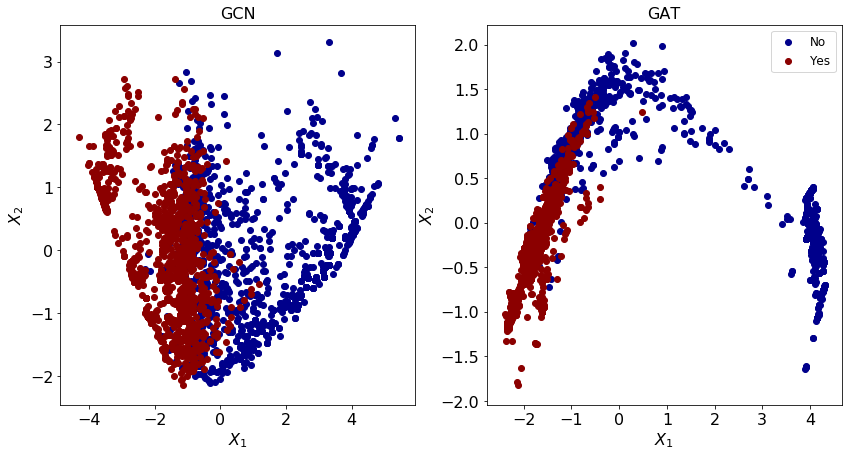

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
import numpy as np

names = ['Yes', 'No']

X_label1 = X_reduced[np.where(patient_label == 1)]
X_label0= X_reduced[np.where(patient_label == 0)]


X_label1_gat = X_reduced_gat[np.where(patient_label == 1)]
X_label0_gat= X_reduced_gat[np.where(patient_label == 0)]

ax1.scatter(X_label0[:, 0], X_label0[:, 1],label=names[1], c='darkblue')
ax1.scatter(X_label1[:, 0], X_label1[:, 1],label=names[0],c='darkred')

ax2.scatter(X_label0_gat[:, 0], X_label0_gat[:, 1],label=names[1], c='darkblue')
ax2.scatter(X_label1_gat[:, 0], X_label1_gat[:, 1],label=names[0],c='darkred')

ax1.set(
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="GCN",
)
#ax1.legend()

ax2.set(
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="GAT",
)
ax2.legend(loc=1, prop={'size': 12})
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(16)

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(16)

plt.savefig('TSNE.jpg')

# GraphSage

In [54]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
batch_size = 3000
num_samples = [10, 5]

In [56]:
generator = GraphSAGENodeGenerator(patient_one_hot_subject, batch_size, num_samples, weighted=True)

In [57]:
train_gen = generator.flow(train_label.index, train_label, shuffle=True)

In [58]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.7,
)

In [59]:
x_inp_gs, x_out_gs = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out_gs)

In [60]:
modelGS = Model(inputs=x_inp_gs, outputs=prediction)
modelGS.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=["acc"],
)



/Users/ben/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
val_gen = generator.flow(val_label.index, val_targets)

history = modelGS.fit(
    train_gen, epochs=20, validation_data=val_gen, verbose=2, shuffle=False
)



Epoch 1/20


/Users/ben/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 - 2s - loss: 0.6891 - acc: 0.5616 - val_loss: 0.6422 - val_acc: 0.7904 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 1s - loss: 0.6729 - acc: 0.5977 - val_loss: 0.6099 - val_acc: 0.9076 - 1s/epoch - 1s/step
Epoch 3/20
1/1 - 1s - loss: 0.6503 - acc: 0.6688 - val_loss: 0.5739 - val_acc: 0.9307 - 1s/epoch - 1s/step
Epoch 4/20
1/1 - 1s - loss: 0.6344 - acc: 0.7299 - val_loss: 0.5394 - val_acc: 0.9307 - 1s/epoch - 1s/step
Epoch 5/20
1/1 - 1s - loss: 0.6177 - acc: 0.7447 - val_loss: 0.5018 - val_acc: 0.9325 - 1s/epoch - 1s/step
Epoch 6/20
1/1 - 1s - loss: 0.5987 - acc: 0.7695 - val_loss: 0.4618 - val_acc: 0.9361 - 1s/epoch - 1s/step
Epoch 7/20
1/1 - 1s - loss: 0.5907 - acc: 0.7684 - val_loss: 0.4292 - val_acc: 0.9449 - 1s/epoch - 1s/step
Epoch 8/20
1/1 - 1s - loss: 0.5709 - acc: 0.7820 - val_loss: 0.3986 - val_acc: 0.9432 - 1s/epoch - 1s/step
Epoch 9/20
1/1 - 1s - loss: 0.5526 - acc: 0.7944 - val_loss: 0.3686 - val_acc: 0.9325 - 1s/epoch - 1s/step
Epoch 10/20
1/1 - 1s - loss: 0.5407 - acc: 0.801

In [62]:
test_gen = generator.flow(test_label.index, test_targets)
test_metrics = modelGS.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(modelGS.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 279ms/step - loss: 0.2954 - acc: 0.8863

Test Set Metrics:
	loss: 0.2954
	acc: 0.8863


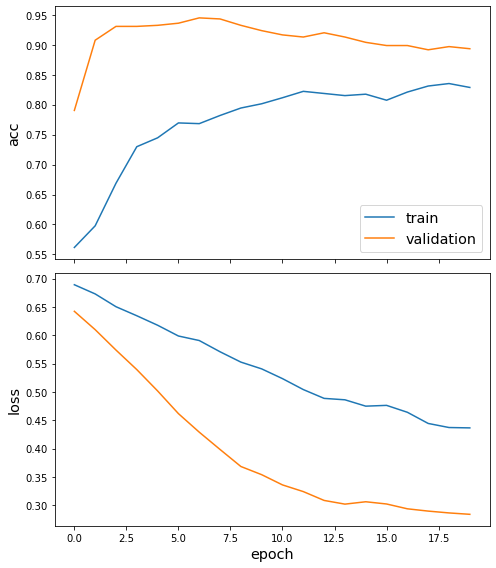

In [63]:
sg.utils.plot_history(history)

In [64]:
all_nodes = patient_label.index
all_mapper = generator.flow(all_nodes)
all_predictions = modelGS.predict(all_mapper)

In [65]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [66]:
df = pd.DataFrame({"Predicted": node_predictions, "True": patient_label})
df.head()

,Predicted,True
patient_id,,
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1


In [67]:
test_nodes = test_label.index
test_gen = generator.flow(test_nodes)
test_predictions = modelGS.predict(test_gen)

In [68]:
test_node_predictions = target_encoding.inverse_transform(test_predictions.squeeze())

In [69]:
df = pd.DataFrame({"Predicted": test_node_predictions, "True": test_label})
df.head()

,Predicted,True
patient_id,,
1827,1,0
1895,1,0
355,0,0
1572,0,0
1852,0,0


In [70]:
print(confusion_matrix(test_label, test_node_predictions))
print(classification_report(test_label, test_node_predictions, digits=4))

[[230  47]
 [ 11 275]]
              precision    recall  f1-score   support

           0     0.9544    0.8303    0.8880       277
           1     0.8540    0.9615    0.9046       286

    accuracy                         0.8970       563
   macro avg     0.9042    0.8959    0.8963       563
weighted avg     0.9034    0.8970    0.8965       563



In [71]:
from sklearn import metrics

In [72]:

roc_auc = metrics.roc_auc_score(test_label, test_node_predictions)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.8959316856428771


In [73]:
embedding_model = Model(inputs=x_inp_gs, outputs=x_out_gs)

In [74]:
emb = embedding_model.predict(all_mapper)

In [75]:
X = emb
y = np.argmax(target_encoding.transform(patient_label), axis=1)

In [76]:
X.shape

(2814, 32)

In [77]:
trans = transform(n_components=2)
X_reduced_gs= trans.fit_transform(X)
X_reduced_gs.shape

(2814, 2)

In [78]:
#3D
trans = transform(n_components=3)
X_reduced_gs= trans.fit_transform(X)
X_reduced_gs.shape

(2814, 3)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'PCA visualization of GraphSAGE embedding'),
 None]

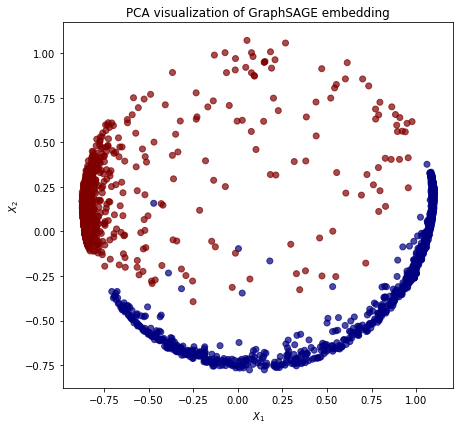

In [79]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced_gs[:, 0],
    X_reduced_gs[:, 1],
    c=patient_label.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GraphSAGE embedding",
)

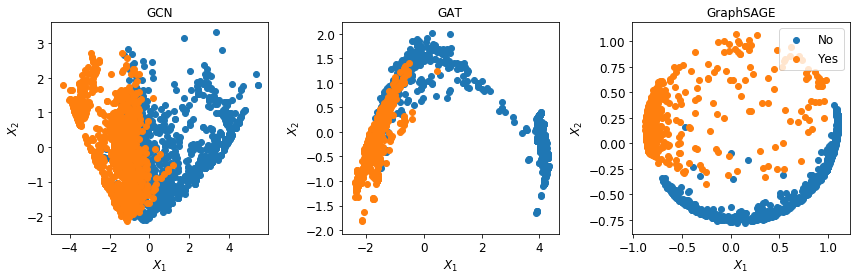

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
import numpy as np

names = ['Yes', 'No']

X_label1 = X_reduced[np.where(patient_label == 1)]
X_label0= X_reduced[np.where(patient_label == 0)]


X_label1_gat = X_reduced_gat[np.where(patient_label == 1)]
X_label0_gat= X_reduced_gat[np.where(patient_label == 0)]


X_label1_gs = X_reduced_gs[np.where(patient_label == 1)]
X_label0_gs= X_reduced_gs[np.where(patient_label == 0)]



ax1.scatter(X_label0[:, 0], X_label0[:, 1],label=names[1], c='tab:blue')
ax1.scatter(X_label1[:, 0], X_label1[:, 1],label=names[0],c='tab:orange')

ax2.scatter(X_label0_gat[:, 0], X_label0_gat[:, 1],label=names[1], c='tab:blue')
ax2.scatter(X_label1_gat[:, 0], X_label1_gat[:, 1],label=names[0],c='tab:orange')

ax3.scatter(X_label0_gs[:, 0], X_label0_gs[:, 1],label=names[1], c='tab:blue')
ax3.scatter(X_label1_gs[:, 0], X_label1_gs[:, 1],label=names[0],c='tab:orange')

ax1.set(
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="GCN",
)
#ax1.legend()

ax2.set(
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="GAT",
)

ax3.set(
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="GraphSAGE",
)

ax3.legend(loc=1, prop={'size': 12})
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(12)

for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(12)

plt.tight_layout()
#plt.savefig('TSNE.jpg')
plt.savefig('PCA_Jaccard.jpg')

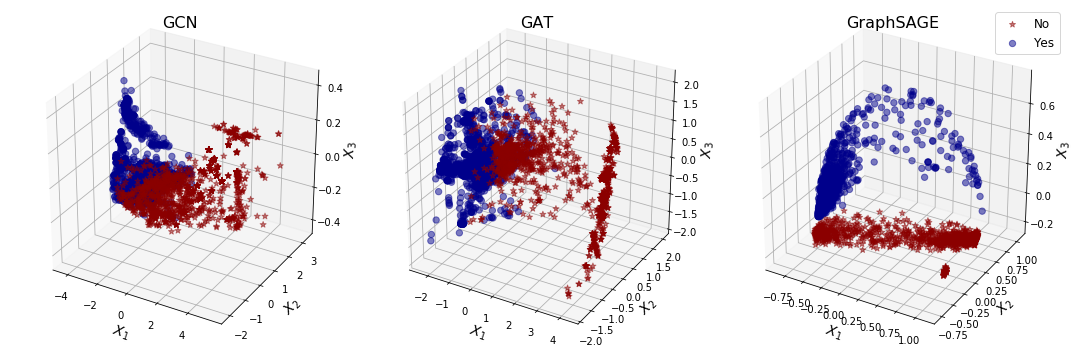

In [81]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt


# imports specific to the plots in this example
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

# Twice as wide as it is tall.
fig = plt.figure(figsize=(15, 5))

#---- First subplot
Xax = X_reduced[:,0]
Yax = X_reduced[:,1]
Zax = X_reduced[:,2]

cdict = {0:'darkred',1:'darkblue'}
labl = {0:'No',1:'Yes'}
marker = {0:'*',1:'o'}
alpha = {0:0.5, 1:0.5}

ax = fig.add_subplot(1,3,1, projection='3d')

y = patient_label
fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("$X_1$", fontsize=14)
ax.set_ylabel("$X_2$", fontsize=14)
ax.set_zlabel("$X_3$", fontsize=14)
ax.set_title('GCN', fontsize=16)



#---- Second subplot
Xax_gat = X_reduced_gat[:,0]
Yax_gat = X_reduced_gat[:,1]
Zax_gat = X_reduced_gat[:,2]


ax2 = fig.add_subplot(1,3,2, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax2.scatter(Xax_gat[ix], Yax_gat[ix], Zax_gat[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax2.set_xlabel("$X_1$", fontsize=14)
ax2.set_ylabel("$X_2$", fontsize=14)
ax2.set_zlabel("$X_3$", fontsize=14)
ax2.set_title('GAT', fontsize=16)


#---- Second subplot
Xax_gs = X_reduced_gs[:,0]
Yax_gs = X_reduced_gs[:,1]
Zax_gs = X_reduced_gs[:,2]


ax3 = fig.add_subplot(1,3,3, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax3.scatter(Xax_gs[ix], Yax_gs[ix], Zax_gs[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax3.set_xlabel("$X_1$", fontsize=14)
ax3.set_ylabel("$X_2$", fontsize=14)
ax3.set_zlabel("$X_3$", fontsize=14)
ax3.set_title('GraphSAGE', fontsize=16)

ax3.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 4. Baseline Node2Vec

In [82]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [83]:
walk_number = 100
walk_length = 5

In [84]:
walker = BiasedRandomWalk(
    patient_one_hot_subject,
    n=walk_number,
    length=walk_length,
    p=0.5,  # defines probability, 1/p, of returning to source node
    q=2.0,  # defines probability, 1/q, for moving to a node away from the source node
)

In [85]:
unsupervised_samples = UnsupervisedSampler(patient_one_hot_subject, nodes=list(patient_one_hot_subject.nodes()), walker=walker)


In [86]:
batch_size = 50
epochs = 2

In [87]:
generator = Node2VecLinkGenerator(patient_one_hot_subject, batch_size)

In [88]:
emb_size = 128
node2vec = Node2Vec(emb_size, generator=generator)

In [89]:
x_inp_n, x_out_n = node2vec.in_out_tensors()

In [90]:

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out_n)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


In [91]:
modelNV = keras.Model(inputs=x_inp_n, outputs=prediction)

modelNV.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/Users/ben/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [92]:
history = modelNV.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/2
44016/44016 [==============================] - 152s 3ms/step - loss: 0.5750 - binary_accuracy: 0.6803
Epoch 2/2
44016/44016 [==============================] - 146s 3ms/step - loss: 0.4764 - binary_accuracy: 0.7860


In [93]:
x_inp_src = x_inp_n[0]
x_out_src = x_out_n[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [94]:
node_gen = Node2VecNodeGenerator(patient_one_hot_subject, batch_size).flow(patient_label.index)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

57/57 [==============================] - 0s 3ms/step


In [95]:
transform = PCA  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

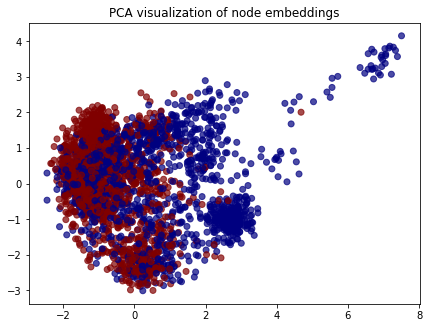

In [96]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(patient_label))}
node_colours = [label_map[target] for target in patient_label]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [97]:
X = node_embeddings
# y holds the corresponding target values
y = np.array(patient_label)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=None, random_state = 2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, test_size=None, random_state = 2)


print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1688, 128)
 y_train = (1688,)
 X_test = (563, 128)
 y_test = (563,)


In [99]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [100]:
y_pred = clf.predict(X_test)

In [101]:
accuracy_score(y_test, y_pred)

0.738898756660746

In [102]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[193  84]
 [ 63 223]]
              precision    recall  f1-score   support

           0     0.7539    0.6968    0.7242       277
           1     0.7264    0.7797    0.7521       286

    accuracy                         0.7389       563
   macro avg     0.7401    0.7382    0.7382       563
weighted avg     0.7399    0.7389    0.7384       563



In [103]:
from sklearn import metrics
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.7382355911236778


# Naive LR

In [104]:
df = pd.read_csv("patient.csv")

In [105]:
X = df.iloc[:, 2:-1]
y = df.iloc[:, -1:]

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=None, random_state = 2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, test_size=None, random_state = 2)


print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1688, 3)
 y_train = (1688, 1)
 X_test = (563, 3)
 y_test = (563, 1)


In [107]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

/Users/ben/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [108]:
y_pred = clf.predict(X_test)

In [109]:
accuracy_score(y_test, y_pred)

0.5719360568383659

In [110]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[149 128]
 [113 173]]
              precision    recall  f1-score   support

           0     0.5687    0.5379    0.5529       277
           1     0.5748    0.6049    0.5894       286

    accuracy                         0.5719       563
   macro avg     0.5717    0.5714    0.5712       563
weighted avg     0.5718    0.5719    0.5714       563



In [111]:
from sklearn import metrics
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.5714006210396103


In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 1)
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,
              min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1,
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


exception calling callback for <Future at 0x7ff19c95fd30 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/ben/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/ben/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/Users/ben/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/ben/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/ben/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/ben/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 531, in apply

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [113]:
forestOpt = RandomForestClassifier(random_state = 1, max_depth = 15,     n_estimators = 500, min_samples_split = 2, min_samples_leaf = 1)

modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

<ipython-input-113-7c57399dab28>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelOpt = forestOpt.fit(X_train, y_train)


In [114]:
accuracy_score(y_test, y_pred)

0.6003552397868561

In [115]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[138 139]
 [ 86 200]]
              precision    recall  f1-score   support

           0     0.6161    0.4982    0.5509       277
           1     0.5900    0.6993    0.6400       286

    accuracy                         0.6004       563
   macro avg     0.6030    0.5987    0.5954       563
weighted avg     0.6028    0.6004    0.5962       563



In [116]:
from sklearn import metrics
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.5987478225745373


## Watch Your Step

In [117]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph import datasets
from stellargraph.utils import plot_history

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

In [118]:
tf.random.set_seed(1234)

In [119]:
generator = AdjacencyPowerGenerator(patient_one_hot_subject, num_powers=10)

/Users/ben/opt/anaconda3/lib/python3.8/site-packages/stellargraph/core/utils.py:134: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)


In [120]:

wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=128,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

In [121]:
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-3))

In [122]:
epochs = 30

batch_size = 10
train_gen = generator.flow(batch_size=batch_size, num_parallel_calls=10)

history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(patient_one_hot_subject.nodes()) // batch_size)
)

Epoch 1/30


/var/folders/s8/4gctkz291zj31k3b6fzqrsfc0000gn/T/__autograph_generated_fileq8_gmm6a.py:12: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests (see: https://github.com/stellargraph/stellargraph/issues/804). It may be difficult to use and may have major changes at any time.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.ld(direct_msg), ag__.ld(ExperimentalWarning)), dict(stacklevel=2), fscope)


281/281 [==============================] - 9s 29ms/step - loss: 19018.5020
Epoch 2/30
281/281 [==============================] - 9s 33ms/step - loss: 18227.7734
Epoch 3/30
281/281 [==============================] - 9s 31ms/step - loss: 13154.4951
Epoch 4/30
281/281 [==============================] - 9s 33ms/step - loss: 6314.5142
Epoch 5/30
281/281 [==============================] - 9s 34ms/step - loss: 3888.0164
Epoch 6/30
281/281 [==============================] - 11s 38ms/step - loss: 3458.2300
Epoch 7/30
281/281 [==============================] - 11s 38ms/step - loss: 3340.7786
Epoch 8/30
281/281 [==============================] - 10s 36ms/step - loss: 3289.4954
Epoch 9/30
281/281 [==============================] - 10s 34ms/step - loss: 3260.1477
Epoch 10/30
281/281 [==============================] - 10s 34ms/step - loss: 3240.9375
Epoch 11/30
281/281 [==============================] - 10s 35ms/step - loss: 3226.0044
Epoch 12/30
281/281 [==============================] - 10s 37ms/s

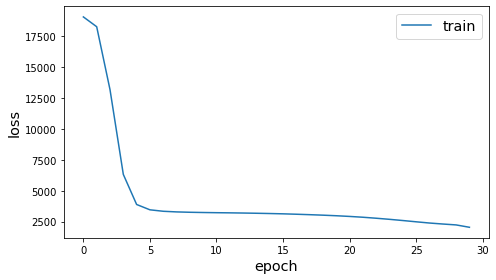

In [123]:
plot_history(history)

In [124]:
embeddings = wys.embeddings()

In [ ]:
# X will hold the 128-dimensional input features
X = embeddings
# y holds the corresponding target values
y = np.array(patient_label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=None, random_state = 2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, test_size=None, random_state = 2)


print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1688, 128)
 y_train = (1688,)
 X_test = (563, 128)
 y_test = (563,)


In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=300, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring='accuracy',
                     solver='lbfgs', tol=0.0001, verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[220  57]
 [ 41 245]]
              precision    recall  f1-score   support

           0     0.8429    0.7942    0.8178       277
           1     0.8113    0.8566    0.8333       286

    accuracy                         0.8259       563
   macro avg     0.8271    0.8254    0.8256       563
weighted avg     0.8268    0.8259    0.8257       563



In [ ]:
from sklearn import metrics
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.825433591679079
